In [177]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from scipy.stats import boxcox
from collections import Counter
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
import warnings

In [766]:
# loading the dataframes
imdb_full_info_df = pd.read_csv('imdb_full_info_df.csv')
inflation_df = pd.read_csv('inflation_data.csv')
cast_score_df = pd.read_csv('cast_score_df.csv')
rt_df = pd.read_csv('year_difference_Biagio_8_march_modif.csv', sep=';')

In [767]:
# dropping irrelevant columns
rt_df.drop(['Unnamed: 0', 'release_date', 'budget', 'domestic_gross',
       'worldwide_gross', 'title', 'imdb_rating', 'cast_1', 'cast_2', 'cast_3',
       'runtime', 'genre', 'director', 'difference', 'Year_scraped'], axis=1, inplace=True)

In [768]:
# dropping irrelevant columns
imdb_full_info_df.drop(['release_date', 'domestic_gross', 'cast_1', 'cast_2', 'cast_3', 'movie_url', 'imdb_id',
       'director', 'rating_check', 'director.1'], axis=1, inplace=True)

In [769]:
# dropping irrelevant columns
cast_score_df.drop(['movie_title', 'cast_1_score', 'cast_2_score', 'cast_3_score'], axis=1, inplace=True)

In [770]:
# combining all 3 dataframes
df = pd.concat([imdb_full_info_df, rt_df, cast_score_df], axis=1)

In [771]:
# filtering out movies produced in 2000
df = df[df['release_year']>2000]

In [772]:
# resetting index
df.reset_index(drop=True, inplace=True)

In [773]:
# extracting runtime values
runtime = []
for i in df['runtime']:
    runtime.append(int(i[2:][:-2]))
    
df['runtime'] = runtime

In [774]:
# processing the inflation_df
inflation_df = inflation_df.sort_values('year', ascending=False)
inflation_df.drop(20, axis=0, inplace=True)
inflation_df.reset_index(inplace=True)
inflation_df.drop(columns=['index'], axis=1, inplace=True)

In [775]:
# calculating the compounded inflation rate for each year with 2019 as base year
for i in range(0, len(inflation_df)):
    if i == 0:
        inflation_df['dollar'][i] = 1
    else:
        inflation_df['dollar'][i] = inflation_df['dollar'][i-1]*(1+inflation_df['inflation'][i-1])

C:\Users\Bosco\AppData\Local\Temp/ipykernel_9104/4206754930.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inflation_df['dollar'][i] = 1
C:\Users\Bosco\AppData\Local\Temp/ipykernel_9104/4206754930.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inflation_df['dollar'][i] = inflation_df['dollar'][i-1]*(1+inflation_df['inflation'][i-1])


In [776]:
# storing the year and compounded rate in a dictionary
inflation_dict = pd.Series(inflation_df.dollar.values, index=inflation_df.year).to_dict()

In [777]:
# adjusting inflation for budget and worldwide_gross
budget_adj = []
worldwide_gross_adj = []

for i in range(0,len(df)):
    inflation_comp = inflation_dict[df['release_year'][i]]
    budget_adj.append(round(df['budget'][i]*inflation_comp))
    worldwide_gross_adj.append(round(df['worldwide_gross'][i]*inflation_comp))

df['budget_adj'] = budget_adj
df['worldwide_gross_adj'] = worldwide_gross_adj

In [778]:
df.drop(['budget', 'worldwide_gross', 'release_year'], axis=1, inplace=True)

In [779]:
# removing space inide string
df['MPA_Ratings'] = df['MPA_Ratings'].str.strip()

In [780]:
# standardizing data
df['MPA_Ratings'].replace({'PG_13':'PG-13'}, inplace=True)

In [781]:
# naming the nulls
df['MPA_Ratings'].fillna(value='Unknown', inplace=True)

In [782]:
df.isna().sum()

title                   0
imdb_rating             0
runtime                 0
genre                   0
tomatometer_score      38
audience_score_rt       9
original_language      19
MPA_Ratings             0
cast_score              0
budget_adj              0
worldwide_gross_adj     0
dtype: int64

In [783]:
df.dropna(inplace=True)

In [784]:
df.reset_index(drop=True, inplace=True)

In [785]:
df.isna().sum()

title                  0
imdb_rating            0
runtime                0
genre                  0
tomatometer_score      0
audience_score_rt      0
original_language      0
MPA_Ratings            0
cast_score             0
budget_adj             0
worldwide_gross_adj    0
dtype: int64

In [786]:
df

title  imdb_rating  runtime  \
0                               Avengers: Endgame          8.4      181   
1     Pirates of the Caribbean: On Stranger Tides          6.6      137   
2                         Avengers: Age of Ultron          7.3      141   
3        Star Wars Episode VII: The Force Awakens          7.9      138   
4                          Avengers: Infinity War          8.5      149   
...                                           ...          ...      ...   
3108                            Gandhi, My Father          7.3      136   
3109                       Tucker & Dale vs. Evil          7.5       89   
3110                                     Redacted          6.1       90   
3111                                   Rudderless          7.4      105   
3112                             Mientras duermes          7.2      102   

                                           genre  tomatometer_score  \
0     ['Action', 'Adventure', 'Drama', 'Sci-Fi']               94.0   
1             ['Action', 'Adventure', 'Fantasy']               33.0   
2              ['Action', 'Adventure', 'Sci-Fi']               76.0   
3              ['Action', 'Adventure', 'Sci-Fi']               93.0   
4              ['Action', 'Adventure', 'Sci-Fi']               85.0   
...                                          ...                ...   
3108           ['Biography', 'Drama', 'History']               47.0   
3109                        ['Comedy', 'Horror']               85.0   
3110                ['Crime', 'Thriller', 'War']               45.0   
3111                ['Comedy', 'Drama', 'Music']               64.0   
3112              ['Crime', 'Drama', 'Thriller']               91.0   

      audience_score_rt original_language MPA_Ratings  cast_score  budget_adj  \
0                  90.0           English       PG-13         761   400000000   
1                  54.0           English       PG-13         308   430707129   
2                  83.0           English       PG-13         599   393679419   
3                  85.0           English       PG-13           0   330043568   
4                  91.0           English       PG-13         887   305280000   
...                 ...               ...         ...         ...         ...   
3108               71.0             Hindi     Unknown           0     6164349   
3109               85.0           English           R           0     5682152   
3110               45.0           English           R           0     6164349   
3111               83.0           English           R           0     5399340   
3112               78.0           Spanish     Unknown           0     5566917   

      worldwide_gross_adj  
0              2797800564  
1              1188380976  
2              1504952267  
3              2226840424  
4              2084410886  
...                   ...  
3108              2484238  
3109              6223994  
3110              1061902  
3111               631182  
3112             10142474  

[3113 rows x 11 columns]

array([[<AxesSubplot:title={'center':'imdb_rating'}>,
        <AxesSubplot:title={'center':'runtime'}>,
        <AxesSubplot:title={'center':'tomatometer_score'}>],
       [<AxesSubplot:title={'center':'audience_score_rt'}>,
        <AxesSubplot:title={'center':'cast_score'}>,
        <AxesSubplot:title={'center':'budget_adj'}>],
       [<AxesSubplot:title={'center':'worldwide_gross_adj'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

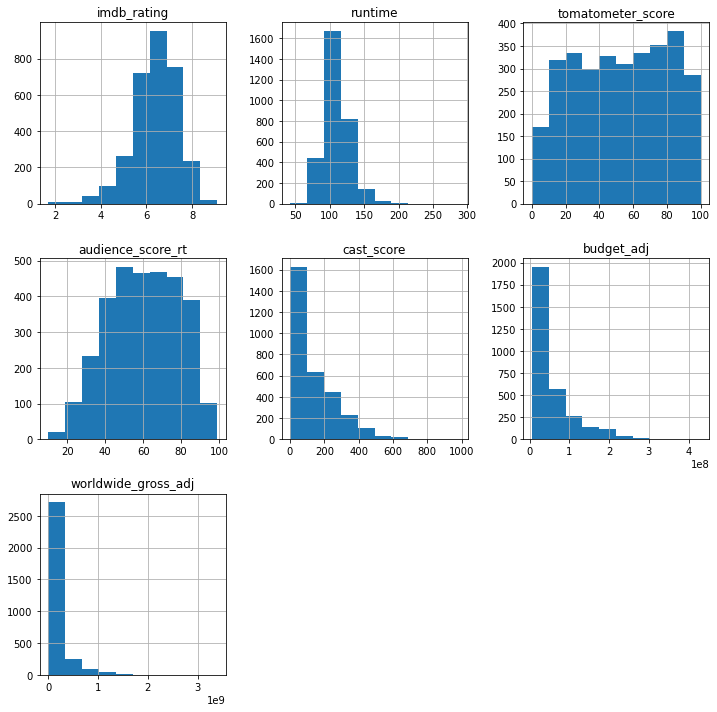

In [199]:
df.hist(figsize=(12,12))

### Removing Outliners

Text(0.5, 1.0, 'runtime')

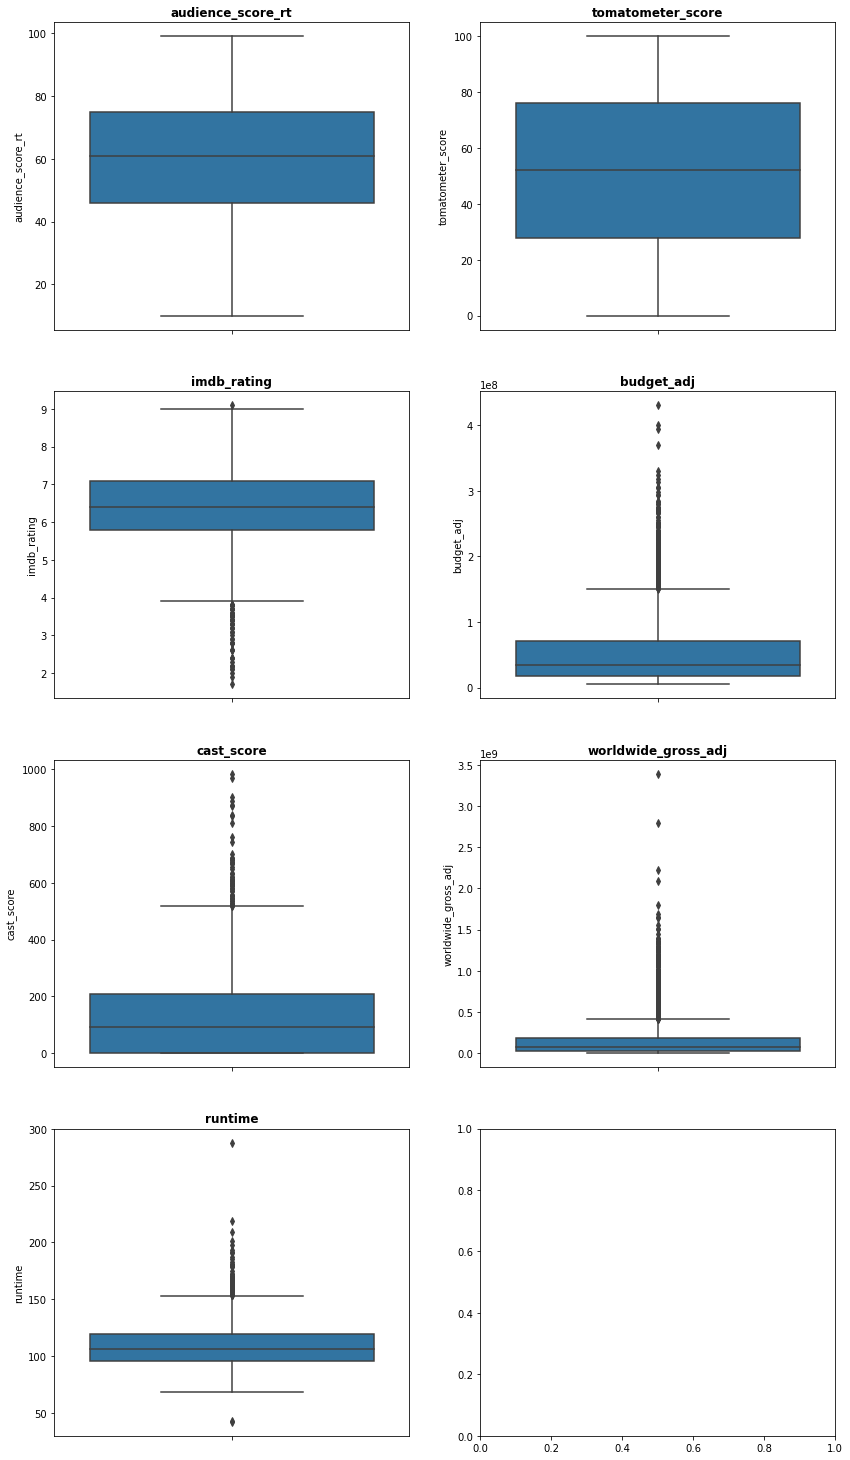

In [175]:
#use boxplot to see outlier distributions on numerical columns
fig2, ax2 = plt.subplots(4,2, figsize=(14,26))
sns.boxplot(y=df['audience_score_rt'], ax = ax2[0,0])
ax2[0,0].set_title('audience_score_rt', fontweight='bold')
sns.boxplot(y=df['tomatometer_score'], ax = ax2[0,1])
ax2[0,1].set_title('tomatometer_score', fontweight='bold')
sns.boxplot(y=df['imdb_rating'], ax = ax2[1,0])
ax2[1,0].set_title('imdb_rating', fontweight='bold')
sns.boxplot(y=df['budget_adj'], ax = ax2[1,1])
ax2[1,1].set_title('budget_adj', fontweight='bold')
sns.boxplot(y=df['cast_score'], ax = ax2[2,0])
ax2[2,0].set_title('cast_score', fontweight='bold')
sns.boxplot(y=df['worldwide_gross_adj'], ax = ax2[2,1])
ax2[2,1].set_title('worldwide_gross_adj', fontweight='bold')
sns.boxplot(y=df['runtime'], ax = ax2[3,0])
ax2[3,0].set_title('runtime', fontweight='bold')

In [162]:
runtime_Q1 = df['runtime'].quantile(0.25)
runtime_Q3 = df['runtime'].quantile(0.75)
runtime_IQR = runtime_Q3 - runtime_Q1    #IQR is interquartile range.

In [164]:
filter = (df['runtime'] >= runtime_Q1 - 1.5 * runtime_IQR) & (df['runtime'] <= runtime_Q3 + 1.5 * runtime_IQR)
df2 = df[filter] 

In [201]:
df.isna().sum()

title                  0
imdb_rating            0
runtime                0
genre                  0
tomatometer_score      0
audience_score_rt      0
original_language      0
MPA_Ratings            0
cast_score             0
budget_adj             0
worldwide_gross_adj    0
dtype: int64

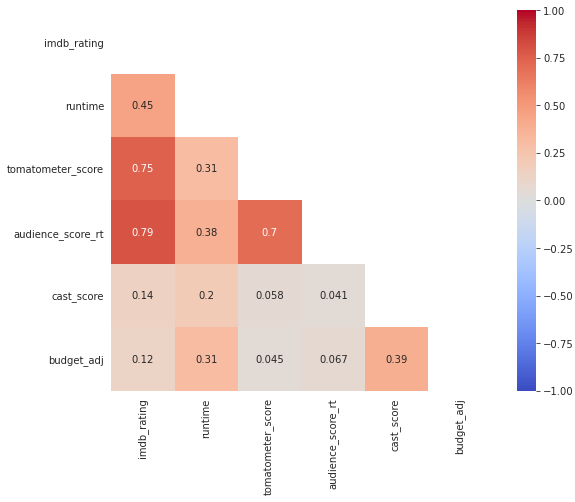

In [508]:
# checking multicollinearity
corr = df.drop('worldwide_gross_adj', axis=1).corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(9, 7))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

### Transformation

<AxesSubplot:ylabel='Count'>

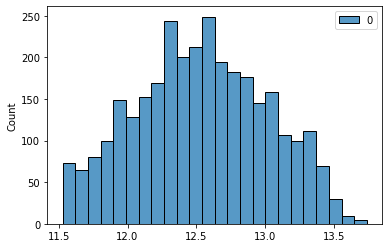

In [220]:
# transforming budget_adj
pt = PowerTransformer(method='box-cox', standardize=False)
budget_adj_tf = pt.fit_transform(df['budget_adj'].to_numpy().reshape(-1,1))
sns.histplot(budget_adj_tf)

In [569]:
# X, y split
X = df.drop(columns=['title', 'genre', 'MPA_Ratings', 'worldwide_gross_adj', 'original_language'], axis=1)
y = df['worldwide_gross_adj']

In [808]:
models = {
    'LR': LinearRegression(),
    'Lasso': Lasso(alpha=0.1),
    'Ridge': Ridge(alpha=1.0),
    'KNN': KNeighborsRegressor(n_neighbors=15)
}
temp = pd.DataFrame(columns=['r2_train','r2_test','adj_r2_train','adj_r2_test'],
                       index=['LR', 'Lasso', 'Ridge', 'KNN'])
def apply_model(models):
    for model_name, model in models.items():
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 100)
       
        pt_X = PowerTransformer(method='box-cox', standardize=False)
        pt_X = pt_X.fit(X_train['budget_adj'].to_numpy().reshape(-1,1))
        budget_adj_train_tf = pt_X.transform(X_train['budget_adj'].to_numpy().reshape(-1,1))
        budget_adj_test_tf = pt_X.transform(X_test['budget_adj'].to_numpy().reshape(-1,1))

        pt_y = PowerTransformer(method='box-cox', standardize=False)
        pt_y = pt_y.fit(y_train.to_numpy().reshape(-1,1))
        y_train = pt_y.transform(y_train.to_numpy().reshape(-1,1))
        y_test = pt_y.transform(y_test.to_numpy().reshape(-1,1))
        
        X_train['budget_adj'] = budget_adj_train_tf
        X_test['budget_adj'] = budget_adj_test_tf
        
        std_scaler = StandardScaler().fit(X_train)
        X_train_scaled = std_scaler.transform(X_train)
        X_test_scaled = std_scaler.transform(X_test)
       
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
                
        temp.loc[model_name, 'r2_train'] = model.score(X_train_scaled, y_train)
        temp.loc[model_name, 'r2_test'] = model.score(X_test_scaled, y_test)
        temp.loc[model_name, 'adj_r2_train'] = 1-((1-model.score(X_train_scaled, y_train))*(len(y_train)-1)/((len(y_train)-X_train.shape[1]-1)))
        temp.loc[model_name, 'adj_r2_test'] = 1-((1-model.score(X_test_scaled, y_test))*(len(y_test)-1)/((len(y_test)-X_test.shape[1]-1)))
    
        if model_name == 'LR':
            features_importance = pd.DataFrame(data = {
                'Attribute': X_train.columns.tolist(),
                'Importance': abs(model.coef_).tolist()[0]
                })
            features_importance = features_importance.sort_values(by='Importance', ascending=False)

    
    return temp, features_importance

In [571]:
apply_model(models)

(       r2_train   r2_test adj_r2_train adj_r2_test
 LR     0.544013  0.536593     0.542911    0.532079
 Lasso  0.543481  0.533968     0.542377    0.529428
 Ridge  0.544013  0.536581     0.542911    0.532067
 KNN    0.593403  0.530841     0.592421    0.526271,
            Attribute  Importance
 5         budget_adj    7.742918
 3  audience_score_rt    2.156664
 2  tomatometer_score    0.825324
 1            runtime    0.589012
 4         cast_score    0.555894
 0        imdb_rating    0.267934)

In [572]:
# X, y split
X = df.drop(columns=['title', 'genre', 'MPA_Ratings', 'worldwide_gross_adj', 'original_language', 'imdb_rating'], axis=1)
y = df['worldwide_gross_adj']

In [573]:
apply_model(models)

(       r2_train   r2_test adj_r2_train adj_r2_test
 LR      0.54386  0.538536     0.542941    0.534797
 Lasso  0.543341  0.535294     0.542422    0.531528
 Ridge   0.54386  0.538537     0.542941    0.534798
 KNN    0.587171  0.532304      0.58634    0.528513,
            Attribute  Importance
 4         budget_adj    7.747046
 2  audience_score_rt    2.286174
 1  tomatometer_score    0.922227
 3         cast_score    0.573690
 0            runtime    0.551266)

In [574]:
# X, y split
X = df.drop(columns=['title', 'genre', 'MPA_Ratings', 'worldwide_gross_adj', 'original_language', 'imdb_rating', 'tomatometer_score'], axis=1)
y = df['worldwide_gross_adj']

In [575]:
apply_model(models)

(       r2_train   r2_test adj_r2_train adj_r2_test
 LR     0.540494  0.534511     0.539754    0.531498
 Lasso      0.54  0.531518     0.539259    0.528486
 Ridge  0.540493  0.534513     0.539754    0.531501
 KNN    0.590367  0.523588     0.589708    0.520504,
            Attribute  Importance
 3         budget_adj    7.681028
 1  audience_score_rt    2.911264
 2         cast_score    0.622300
 0            runtime    0.501553)

In [787]:
df_all = df.drop(columns=['title', 'imdb_rating'], axis=1)
df_all

runtime                                       genre  tomatometer_score  \
0         181  ['Action', 'Adventure', 'Drama', 'Sci-Fi']               94.0   
1         137          ['Action', 'Adventure', 'Fantasy']               33.0   
2         141           ['Action', 'Adventure', 'Sci-Fi']               76.0   
3         138           ['Action', 'Adventure', 'Sci-Fi']               93.0   
4         149           ['Action', 'Adventure', 'Sci-Fi']               85.0   
...       ...                                         ...                ...   
3108      136           ['Biography', 'Drama', 'History']               47.0   
3109       89                        ['Comedy', 'Horror']               85.0   
3110       90                ['Crime', 'Thriller', 'War']               45.0   
3111      105                ['Comedy', 'Drama', 'Music']               64.0   
3112      102              ['Crime', 'Drama', 'Thriller']               91.0   

      audience_score_rt original_language MPA_Ratings  cast_score  budget_adj  \
0                  90.0           English       PG-13         761   400000000   
1                  54.0           English       PG-13         308   430707129   
2                  83.0           English       PG-13         599   393679419   
3                  85.0           English       PG-13           0   330043568   
4                  91.0           English       PG-13         887   305280000   
...                 ...               ...         ...         ...         ...   
3108               71.0             Hindi     Unknown           0     6164349   
3109               85.0           English           R           0     5682152   
3110               45.0           English           R           0     6164349   
3111               83.0           English           R           0     5399340   
3112               78.0           Spanish     Unknown           0     5566917   

      worldwide_gross_adj  
0              2797800564  
1              1188380976  
2              1504952267  
3              2226840424  
4              2084410886  
...                   ...  
3108              2484238  
3109              6223994  
3110              1061902  
3111               631182  
3112             10142474  

[3113 rows x 9 columns]

In [714]:
# filtering out insignificant languages
#language_filter = df_all['original_language'].value_counts()[df_all['original_language'].value_counts()>4].index.tolist()
#df_all = df_all[df_all['original_language'].isin(language_filter)]

In [733]:
df_all['original_language'].value_counts()

English                     2940
Chinese                       28
French (France)               26
English (United Kingdom)      18
French (Canada)               14
Hindi                         14
Spanish                       11
Japanese                       9
Spanish (Spain)                6
German                         6
Korean                         5
Italian                        5
Russian                        4
Portuguese (Brazil)            3
French                         2
Danish                         2
Thai                           2
English (Australia)            2
Dutch                          2
Telugu                         2
Unknown language               2
Czech                          2
Tamil                          1
Desiree Akhavan                1
Catalan                        1
Arabic                         1
Bosnian                        1
Swedish                        1
Aramaic                        1
Norwegian                      1
Name: orig

In [788]:
df_eng = df_all
df_eng

runtime                                       genre  tomatometer_score  \
0         181  ['Action', 'Adventure', 'Drama', 'Sci-Fi']               94.0   
1         137          ['Action', 'Adventure', 'Fantasy']               33.0   
2         141           ['Action', 'Adventure', 'Sci-Fi']               76.0   
3         138           ['Action', 'Adventure', 'Sci-Fi']               93.0   
4         149           ['Action', 'Adventure', 'Sci-Fi']               85.0   
...       ...                                         ...                ...   
3108      136           ['Biography', 'Drama', 'History']               47.0   
3109       89                        ['Comedy', 'Horror']               85.0   
3110       90                ['Crime', 'Thriller', 'War']               45.0   
3111      105                ['Comedy', 'Drama', 'Music']               64.0   
3112      102              ['Crime', 'Drama', 'Thriller']               91.0   

      audience_score_rt original_language MPA_Ratings  cast_score  budget_adj  \
0                  90.0           English       PG-13         761   400000000   
1                  54.0           English       PG-13         308   430707129   
2                  83.0           English       PG-13         599   393679419   
3                  85.0           English       PG-13           0   330043568   
4                  91.0           English       PG-13         887   305280000   
...                 ...               ...         ...         ...         ...   
3108               71.0             Hindi     Unknown           0     6164349   
3109               85.0           English           R           0     5682152   
3110               45.0           English           R           0     6164349   
3111               83.0           English           R           0     5399340   
3112               78.0           Spanish     Unknown           0     5566917   

      worldwide_gross_adj  
0              2797800564  
1              1188380976  
2              1504952267  
3              2226840424  
4              2084410886  
...                   ...  
3108              2484238  
3109              6223994  
3110              1061902  
3111               631182  
3112             10142474  

[3113 rows x 9 columns]

In [789]:
# categorizing english and non-english
for i in range(0, len(df_eng['original_language'])):
    if (df_eng['original_language'][i] == 'English'):
        df_eng['original_language'][i] = df_eng['original_language'][i]
    else:
        df_eng['original_language'][i] = 'Non-English'

C:\Users\Bosco\AppData\Local\Temp/ipykernel_9104/3033154827.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eng['original_language'][i] = df_eng['original_language'][i]
C:\Users\Bosco\AppData\Local\Temp/ipykernel_9104/3033154827.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eng['original_language'][i] = 'Non-English'


In [790]:
# filtering out insignificant MPA_Ratings
df_eng = df_eng[(df_eng['MPA_Ratings'] != df_eng['MPA_Ratings'].value_counts()[df_eng['MPA_Ratings'].value_counts()<10].index[0]) & (df_eng['MPA_Ratings'] != df_eng['MPA_Ratings'].value_counts()[df_eng['MPA_Ratings'].value_counts()<10].index[1])]

In [791]:
# filtering out insignificant genre
df_eng = df_eng[~df_eng.genre.str.contains('Short')]

In [792]:
df_eng.reset_index(drop=True, inplace=True)

In [793]:
# one hot encoding for genre (multiple values)
x = df_eng['genre'].apply(eval)
x = x.apply(Counter)
x = pd.json_normalize(x)
x = x.replace(np.nan, 0)
x = x.astype('int')

In [794]:
df_eng.drop(['genre'], axis=1, inplace=True)

In [795]:
df_eng

runtime  tomatometer_score  audience_score_rt original_language  \
0         181               94.0               90.0           English   
1         137               33.0               54.0           English   
2         141               76.0               83.0           English   
3         138               93.0               85.0           English   
4         149               85.0               91.0           English   
...       ...                ...                ...               ...   
3102      136               47.0               71.0       Non-English   
3103       89               85.0               85.0           English   
3104       90               45.0               45.0           English   
3105      105               64.0               83.0           English   
3106      102               91.0               78.0       Non-English   

     MPA_Ratings  cast_score  budget_adj  worldwide_gross_adj  
0          PG-13         761   400000000           2797800564  
1          PG-13         308   430707129           1188380976  
2          PG-13         599   393679419           1504952267  
3          PG-13           0   330043568           2226840424  
4          PG-13         887   305280000           2084410886  
...          ...         ...         ...                  ...  
3102     Unknown           0     6164349              2484238  
3103           R           0     5682152              6223994  
3104           R           0     6164349              1061902  
3105           R           0     5399340               631182  
3106     Unknown           0     5566917             10142474  

[3107 rows x 8 columns]

In [796]:
x

Action  Adventure  Drama  Sci-Fi  Fantasy  Thriller  Animation  Family  \
0          1          1      1       1        0         0          0       0   
1          1          1      0       0        1         0          0       0   
2          1          1      0       1        0         0          0       0   
3          1          1      0       1        0         0          0       0   
4          1          1      0       1        0         0          0       0   
...      ...        ...    ...     ...      ...       ...        ...     ...   
3102       0          0      1       0        0         0          0       0   
3103       0          0      0       0        0         0          0       0   
3104       0          0      0       0        0         1          0       0   
3105       0          0      1       0        0         0          0       0   
3106       0          0      1       0        0         1          0       0   

      Musical  Comedy  ...  Mystery  Crime  Western  History  Sport  Horror  \
0           0       0  ...        0      0        0        0      0       0   
1           0       0  ...        0      0        0        0      0       0   
2           0       0  ...        0      0        0        0      0       0   
3           0       0  ...        0      0        0        0      0       0   
4           0       0  ...        0      0        0        0      0       0   
...       ...     ...  ...      ...    ...      ...      ...    ...     ...   
3102        0       0  ...        0      0        0        1      0       0   
3103        0       1  ...        0      0        0        0      0       1   
3104        0       0  ...        0      1        0        0      0       0   
3105        0       1  ...        0      0        0        0      0       0   
3106        0       0  ...        0      1        0        0      0       0   

      Music  War  Biography  Documentary  
0         0    0          0            0  
1         0    0          0            0  
2         0    0          0            0  
3         0    0          0            0  
4         0    0          0            0  
...     ...  ...        ...          ...  
3102      0    0          1            0  
3103      0    0          0            0  
3104      0    1          0            0  
3105      1    0          0            0  
3106      0    0          0            0  

[3107 rows x 21 columns]

In [797]:
df_eng_num = df_eng._get_numeric_data()
df_eng_num

runtime  tomatometer_score  audience_score_rt  cast_score  budget_adj  \
0         181               94.0               90.0         761   400000000   
1         137               33.0               54.0         308   430707129   
2         141               76.0               83.0         599   393679419   
3         138               93.0               85.0           0   330043568   
4         149               85.0               91.0         887   305280000   
...       ...                ...                ...         ...         ...   
3102      136               47.0               71.0           0     6164349   
3103       89               85.0               85.0           0     5682152   
3104       90               45.0               45.0           0     6164349   
3105      105               64.0               83.0           0     5399340   
3106      102               91.0               78.0           0     5566917   

      worldwide_gross_adj  
0              2797800564  
1              1188380976  
2              1504952267  
3              2226840424  
4              2084410886  
...                   ...  
3102              2484238  
3103              6223994  
3104              1061902  
3105               631182  
3106             10142474  

[3107 rows x 6 columns]

In [798]:
df_eng_cat = df_eng.select_dtypes('object')
df_eng_cat

original_language MPA_Ratings
0              English       PG-13
1              English       PG-13
2              English       PG-13
3              English       PG-13
4              English       PG-13
...                ...         ...
3102       Non-English     Unknown
3103           English           R
3104           English           R
3105           English           R
3106       Non-English     Unknown

[3107 rows x 2 columns]

In [799]:
df_eng_cat = pd.get_dummies(df_eng_cat, drop_first=True)

In [801]:
df_combined = pd.concat([df_eng_num, df_eng_cat, x], axis=1)

In [802]:
df_combined

runtime  tomatometer_score  audience_score_rt  cast_score  budget_adj  \
0         181               94.0               90.0         761   400000000   
1         137               33.0               54.0         308   430707129   
2         141               76.0               83.0         599   393679419   
3         138               93.0               85.0           0   330043568   
4         149               85.0               91.0         887   305280000   
...       ...                ...                ...         ...         ...   
3102      136               47.0               71.0           0     6164349   
3103       89               85.0               85.0           0     5682152   
3104       90               45.0               45.0           0     6164349   
3105      105               64.0               83.0           0     5399340   
3106      102               91.0               78.0           0     5566917   

      worldwide_gross_adj  original_language_Non-English  MPA_Ratings_PG  \
0              2797800564                              0               0   
1              1188380976                              0               0   
2              1504952267                              0               0   
3              2226840424                              0               0   
4              2084410886                              0               0   
...                   ...                            ...             ...   
3102              2484238                              1               0   
3103              6223994                              0               0   
3104              1061902                              0               0   
3105               631182                              0               0   
3106             10142474                              1               0   

      MPA_Ratings_PG-13  MPA_Ratings_R  ...  Mystery  Crime  Western  History  \
0                     1              0  ...        0      0        0        0   
1                     1              0  ...        0      0        0        0   
2                     1              0  ...        0      0        0        0   
3                     1              0  ...        0      0        0        0   
4                     1              0  ...        0      0        0        0   
...                 ...            ...  ...      ...    ...      ...      ...   
3102                  0              0  ...        0      0        0        1   
3103                  0              1  ...        0      0        0        0   
3104                  0              1  ...        0      1        0        0   
3105                  0              1  ...        0      0        0        0   
3106                  0              0  ...        0      1        0        0   

      Sport  Horror  Music  War  Biography  Documentary  
0         0       0      0    0          0            0  
1         0       0      0    0          0            0  
2         0       0      0    0          0            0  
3         0       0      0    0          0            0  
4         0       0      0    0          0            0  
...     ...     ...    ...  ...        ...          ...  
3102      0       0      0    0          1            0  
3103      0       1      0    0          0            0  
3104      0       0      0    1          0            0  
3105      0       0      1    0          0            0  
3106      0       0      0    0          0            0  

[3107 rows x 32 columns]

In [803]:
# X, y split
X = df_combined.drop(columns=['worldwide_gross_adj'], axis=1)
y = df_combined['worldwide_gross_adj']

In [807]:
apply_model(models)

(       r2_train   r2_test adj_r2_train adj_r2_test
 LR     0.633797  0.574255     0.629169    0.551885
 Lasso  0.631664  0.573439     0.627009    0.551027
 Ridge  0.633796  0.574308     0.629168    0.551941
 KNN    0.542294  0.440723      0.53651    0.411337,
                         Attribute  Importance
 4                      budget_adj    6.857470
 2               audience_score_rt    2.796523
 26                         Horror    1.671427
 1               tomatometer_score    1.156857
 3                      cast_score    1.009997
 0                         runtime    0.858658
 19                         Comedy    0.770256
 17                         Family    0.436564
 5   original_language_Non-English    0.274539
 21                        Mystery    0.182138
 11                      Adventure    0.179582
 15                       Thriller    0.114955
 27                          Music    0.040447
 30                    Documentary    0.025531
 18                        Musical

In [715]:
# filtering out insignificant MPA_Ratings
df_all = df_all[(df_all['MPA_Ratings'] != df_all['MPA_Ratings'].value_counts()[df_all['MPA_Ratings'].value_counts()<10].index[0]) & (df_all['MPA_Ratings'] != df_all['MPA_Ratings'].value_counts()[df_all['MPA_Ratings'].value_counts()<10].index[1])]

In [716]:
# filtering out insignificant genre
df_all = df_all[~df_all.genre.str.contains('Short')]

In [717]:
# one hot encoding for genre (multiple values)
x = df_all['genre'].apply(eval)
x = x.apply(Counter)
x = pd.json_normalize(x)
x = x.replace(np.nan, 0)
x = x.astype('int')

In [718]:
df_all.drop(['genre'], axis=1, inplace=True)

In [719]:
df_all.reset_index(drop=True, inplace=True)

In [720]:
df_num = df_all._get_numeric_data()
df_num

runtime  tomatometer_score  audience_score_rt  cast_score  budget_adj  \
0         181               94.0               90.0         761   400000000   
1         137               33.0               54.0         308   430707129   
2         141               76.0               83.0         599   393679419   
3         138               93.0               85.0           0   330043568   
4         149               85.0               91.0         887   305280000   
...       ...                ...                ...         ...         ...   
3071      136               47.0               71.0           0     6164349   
3072       89               85.0               85.0           0     5682152   
3073       90               45.0               45.0           0     6164349   
3074      105               64.0               83.0           0     5399340   
3075      102               91.0               78.0           0     5566917   

      worldwide_gross_adj  
0              2797800564  
1              1188380976  
2              1504952267  
3              2226840424  
4              2084410886  
...                   ...  
3071              2484238  
3072              6223994  
3073              1061902  
3074               631182  
3075             10142474  

[3076 rows x 6 columns]

In [721]:
df_cat = df_all.select_dtypes('object')
df_cat

original_language MPA_Ratings
0              English       PG-13
1              English       PG-13
2              English       PG-13
3              English       PG-13
4              English       PG-13
...                ...         ...
3071             Hindi     Unknown
3072           English           R
3073           English           R
3074           English           R
3075           Spanish     Unknown

[3076 rows x 2 columns]

In [722]:
df_cat = pd.get_dummies(df_cat, drop_first=True)

In [724]:
df_combined = pd.concat([df_num, df_cat, x], axis=1)

In [730]:
# X, y split
X = df_combined.drop(columns=['worldwide_gross_adj'], axis=1)
y = df_combined['worldwide_gross_adj']

In [731]:
apply_model(models)

(       r2_train   r2_test adj_r2_train adj_r2_test
 LR     0.641958  0.560069     0.635887    0.528645
 Lasso  0.638163  0.562255     0.632028    0.530988
 Ridge  0.641958  0.560081     0.635887    0.528659
 KNN    0.548934  0.408091     0.541285    0.365812,
                                      Attribute  Importance
 4                                   budget_adj    6.597319
 2                            audience_score_rt    2.586005
 36                                      Horror    1.527884
 22                                       Drama    1.432867
 1                            tomatometer_score    1.094363
 5                    original_language_English    1.029061
 3                                   cast_score    0.993364
 18                               MPA_Ratings_R    0.800887
 7            original_language_French (Canada)    0.760322
 29                                      Comedy    0.711555
 0                                      runtime    0.701514
 34                

In [611]:
# X, y split
X = df_combined.drop(columns=['worldwide_gross_adj', 'original_language_Aramaic',
       'original_language_Bosnian', 'original_language_Catalan',
       'original_language_Chinese', 'original_language_Czech',
       'original_language_Danish', 'original_language_Desiree Akhavan',
       'original_language_Dutch', 'original_language_English',
       'original_language_English (Australia)',
       'original_language_English (United Kingdom)',
       'original_language_French', 'original_language_French (Canada)',
       'original_language_French (France)', 'original_language_German',
       'original_language_Hindi', 'original_language_Italian',
       'original_language_Japanese', 'original_language_Korean',
       'original_language_Norwegian', 'original_language_Portuguese (Brazil)',
       'original_language_Russian', 'original_language_Spanish',
       'original_language_Spanish (Spain)', 'original_language_Swedish',
       'original_language_Tamil', 'original_language_Telugu',
       'original_language_Thai', 'original_language_Unknown language'], axis=1)
y = df_combined['worldwide_gross_adj']

In [612]:
apply_model(models)

(       r2_train   r2_test adj_r2_train adj_r2_test
 LR     0.627002  0.604486      0.62199    0.582327
 Lasso   0.62477  0.606195     0.619729    0.584132
 Ridge  0.627001  0.604514      0.62199    0.582356
 KNN    0.533247  0.477993     0.526976    0.448746,
               Attribute  Importance
 4            budget_adj    6.586620
 2     audience_score_rt    2.833834
 27               Horror    1.677631
 13                Drama    1.434066
 8         MPA_Ratings_R    1.119100
 1     tomatometer_score    1.046962
 3            cast_score    0.908929
 0               runtime    0.856357
 20               Comedy    0.731687
 23                Crime    0.667654
 29                  War    0.638429
 10  MPA_Ratings_Unknown    0.588544
 26                Sport    0.575505
 24              Western    0.536685
 30            Biography    0.502601
 18               Family    0.494915
 25              History    0.436078
 6        MPA_Ratings_PG    0.322048
 9      MPA_Ratings_TVMA    0.314297